# Imports

In [50]:
from Twitter import TwitterAccess
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from collections import Counter
pd.options.display.max_colwidth = None
import nltk
import string
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from spellchecker import SpellChecker
import random
import numpy as np
from multiprocessing import  Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin # ???
from sklearn.utils.validation import check_X_y, check_is_fitted # ???
from scipy import sparse #???
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to /u/arsaikia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Architecture

In [51]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def pr(self, x, y_i, y):
        p = x[y==y_i].sum(0)
        return (p+1) / ((y==y_i).sum()+1)
    
    def fit(self, x, y):
        # Check that X and y have correct shape
#         y = y
        x, y = check_X_y(x, y, accept_sparse=True)
        self._r = sparse.csr_matrix(np.log(self.pr(x,1,y) / self.pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs, solver ='liblinear').fit(x_nb, y)
        self.coef_ = self._clf.coef_
        return self

# Train-Validate

In [52]:

def train_validate(X, y, min_df, threshold_plot=False):
    le = LabelEncoder()
    y = le.fit_transform(y)

    tfv = TfidfVectorizer(tokenizer=nltk.casual_tokenize, min_df=min_df,  max_features=30000, 
                strip_accents='unicode', analyzer='word',ngram_range=(1,3),
                use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')
    X = tfv.fit_transform(X).tocsr()

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    

    model = NbSvmClassifier(C=1, dual=True, n_jobs=1)

    model.fit(X_train, y_train)
    preds_valid = model.predict(X_valid)
#     proba_valid = model.predict_proba(X_valid)[:,1]
    preds_train = model.predict(X_train)
#     proba_train = model.predict_proba(X_train)[:,1]
    
    print('##### TRAINING DATA #####')

    print(classification_report(y_train, preds_train))
    try:
        print('AUC: ',  roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    except:
        print('AUC: ',  roc_auc_score(y_train, model.predict_proba(X_train), multi_class ='ovr'))
        
    print('##### VALIDATION DATA #####')
    print(classification_report(y_valid, preds_valid))
    try:
        print('AUC: ',  roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1]))
    except:
        print('AUC: ',  roc_auc_score(y_valid, model.predict_proba(X_valid), multi_class ='ovr'))
        
    if threshold_plot:
        thresholds  = []
        scores = []
        for th in range(1,10):
            thresholds.append(th/10)

            scores.append(f1_score(y_valid, model.predict_proba(X_valid)[:,1] > (th/10), average = 'macro'))

        plt.plot(thresholds, scores)
    return model, tfv


# Test

In [53]:
def test(X, y, X_test,y_test,min_df, threshold = 0.5):
    le = LabelEncoder()
    y = le.fit_transform(y)

    tfv = TfidfVectorizer(tokenizer=nltk.casual_tokenize, min_df=min_df,  max_features=30000, 
                strip_accents='unicode', analyzer='word',ngram_range=(1,1),
                use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')
    X = tfv.fit_transform(X).tocsr()

    model = NbSvmClassifier(C=1, dual=True, n_jobs=1)

    model.fit(X, y)

    y_test = le.transform(y_test)
    X_test = tfv.transform(X_test).tocsr()
    
    print('##### TEST DATA #####')
    print(X_test.shape, y_test.shape)
#     proba_test = model.predict_proba(X_test)[:,1]

    if len(le.classes_) > 2:
        preds_test = model.predict(X_test)
        print(classification_report(y_test, preds_test))
        print('AUC: ',  roc_auc_score(y_test, model.predict_proba(X_test), multi_class ='ovr'))
    else:
        
        print(classification_report(y_test, (model.predict_proba(X_test)[:,1] > threshold).astype('int')))
        print('AUC: ',  roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


    return model, tfv



In [54]:
def two_pred(preds):
    if preds[0] == 1:
        return 1
    else:
        if preds[1] == 0:
            return 0
        else:
            return 2

def two_stage(X_test, y_test, model1, model2, tfv1, tfv2, th1, th2):
    
    X_test1 = tfv1.transform(X_test).tocsr()
    X_test2 = tfv2.transform(X_test).tocsr()
    
    # 0 grp 1 inv 2 oth
    
    y_pred1 = (model1.predict_proba(X_test1)[:,1] > th1).astype('int') # 0 inv 1 not inv
    y_pred1 = np.array([1] *len(y_pred1)) ^ y_pred1 # 0 not inv 1 inv
    
    y_pred2 = (model2.predict_proba(X_test2)[:,1] > th2).astype('int') # 0 grp 1 oth
    
    
    preds = list(tuple(zip(y_pred1,y_pred2)))
    preds_test = np.array(list(map( two_pred, preds)))
    
    le = LabelEncoder()
    y = le.fit_transform(y_test)
    
    print(classification_report(y, preds_test))

    

In [43]:
A = np.array([1,1,0,0])
B = np.array([0,1,0,1])
def two_pred(preds):
    if preds[0] == 1:
        return 1
    else:
        if preds[1] == 0:
            return 0
        else:
            return 2
preds = list(tuple(zip(A,B)))
list(map( two_pred, preds))


[1, 1, 0, 2]

# Load Data

In [55]:
PREPROCESSED = '../preprocessed/'

olid = pd.read_csv(PREPROCESSED + 'olid.csv')
olid_traina = olid[~pd.isna(olid['tweet_cleaned'])]
olid_trainb = olid_traina[~pd.isna(olid_traina['subtask_b'])]
olid_trainc = olid_traina[~pd.isna(olid_traina['subtask_c'])]
olid_traincii = olid_traina[~pd.isna(olid_traina['subtask_c_ii'])]
olid_trainciii = olid_traina[~pd.isna(olid_traina['subtask_c_iii'])]


olid_testa = pd.read_csv(PREPROCESSED + 'olid-levela.csv')
olid_testa = olid_testa[~pd.isna(olid_testa['tweet_cleaned'])]

olid_testb = pd.read_csv(PREPROCESSED + 'olid-levelb.csv')
olid_testb = olid_testb[~pd.isna(olid_testb['tweet_cleaned'])]

olid_testc = pd.read_csv(PREPROCESSED + 'olid-levelc.csv')
olid_testc = olid_testc[~pd.isna(olid_testc['tweet_cleaned'])]
olid_testcii = olid_testc[~pd.isna(olid_testc['subtask_c_ii'])]
olid_testciii = olid_testc[~pd.isna(olid_testc['subtask_c_iii'])]


In [7]:
olid_testc

,id,tweet,subtask_c,tweet_cleaned,subtask_c_ii,subtask_c_iii
0,15923,"#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA Democrats Support Antifa, Muslim Brotherhood, MS13, ISIS, Pedophilia, Child Trafficking, Taxpayer Funded Abortion’s, Election Fraud, Sedition And Treason!!! #LockThemAllUp #WWG1WGA #QAnon ⁦@USER URL",OTH,democrats support antifa muslim brotherhood ms13 isis pedophilia child trafficking taxpayer funded abortion’s election fraud sedition and treason ⁦,OTH,OTH
1,60133,#NoPasaran: Unity demo to oppose the far-right in #London – #antifa #Oct13 — Enough is Enough! URL,GRP,unity demo to oppose the farright in – — enough is enough,OTH,GRP
2,83681,. . . What the fuck did he do this time?,IND,what the fuck did he do this time,IND,NaN
3,65507,@USER Do you get the feeling he is kissing @USER behind so he can humiliate him later?,OTH,do you get the feeling he is kissing behind so he can humiliate him later,OTH,OTH
4,34263,#StopKavanaugh he is liar like the rest of the #GOP URL,IND,he is liar like the rest of the,IND,NaN
...,...,...,...,...,...,...
208,30778,#StopEtchecopar? Fuck you all 🖕🖕🖕🖕🖕 Que florezcan mil Baby Etchecopar 🌻🌻🌻,IND,fuck you all que florezcan mil baby etchecopar,IND,NaN
209,22569,"#Antifa are mentally unstable cowards, pretending to be relevant. URL",GRP,are mentally unstable cowards pretending to be relevant,OTH,GRP
210,48938,@USER @USER And Browning looked like dog shit against the same FCS school. What’s your point?,IND,and browning looked like dog shit against the same fcs school what’s your point,IND,NaN
211,41438,All two of them taste like ass. URL,GRP,all two of them taste like ass,OTH,GRP


# Subtask A

(8870, 1177) (4369, 1177) (8870,) (4369,)
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      5922
           1       0.83      0.43      0.57      2948

    accuracy                           0.78      8870
   macro avg       0.80      0.69      0.71      8870
weighted avg       0.79      0.78      0.76      8870

AUC:  0.8362388973892625
              precision    recall  f1-score   support

           0       0.76      0.95      0.84      2917
           1       0.79      0.39      0.52      1452

    accuracy                           0.76      4369
   macro avg       0.77      0.67      0.68      4369
weighted avg       0.77      0.76      0.74      4369

AUC:  0.7659210848158086
(859, 1177) (859,)
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       619
           1       0.75      0.51      0.61       240

    accuracy                           0.82       859
   macro avg     

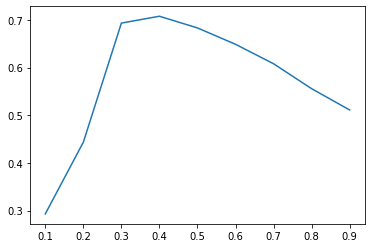

In [38]:
modela, tfva = train_validate(olid_traina['tweet_cleaned'], olid_traina['subtask_a'], 20, True)
test(olid_traina['tweet_cleaned'], olid_traina['subtask_a'], olid_testa['tweet_cleaned'], olid_testa['subtask_a'], 20, 0.4)

# Subtask B

(2948, 1349) (1452, 1349) (2948,) (1452,)
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2599
           1       0.84      0.05      0.09       349

    accuracy                           0.89      2948
   macro avg       0.86      0.52      0.51      2948
weighted avg       0.88      0.89      0.84      2948

AUC:  0.8650572018552429
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1277
           1       0.33      0.01      0.02       175

    accuracy                           0.88      1452
   macro avg       0.61      0.50      0.48      1452
weighted avg       0.81      0.88      0.82      1452

AUC:  0.6461013536189731
(240, 1349) (240,)
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       213
           1       0.44      0.41      0.42        27

    accuracy                           0.88       240
   macro avg     

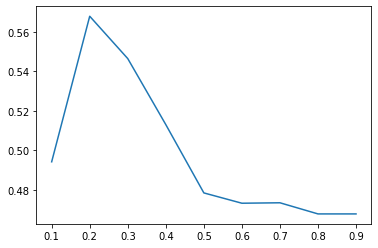

In [39]:
modelb, tfvb = train_validate(olid_trainb['tweet_cleaned'], olid_trainb['subtask_b'],7, True)
test(olid_trainb['tweet_cleaned'], olid_trainb['subtask_b'], olid_testb['tweet_cleaned'], olid_testb['subtask_b'],7, 0.2)

# Subtask C (i)

In [6]:
modelc, tfvc = train_validate(olid_trainc['tweet_cleaned'], olid_trainc['subtask_c'],5)
test(olid_trainc['tweet_cleaned'], olid_trainc['subtask_c'], olid_testc['tweet_cleaned'], olid_testc['subtask_c'],5)
# 0 grp 1 inv 2 oth

(2596, 1790) (1280, 1790) (2596,) (1280,)
##### TRAINING DATA #####
              precision    recall  f1-score   support

           0       0.76      0.57      0.65       735
           1       0.75      0.95      0.84      1600
           2       1.00      0.01      0.02       261

    accuracy                           0.75      2596
   macro avg       0.84      0.51      0.50      2596
weighted avg       0.78      0.75      0.70      2596

AUC:  0.8833370040571302
##### VALIDATION DATA #####
              precision    recall  f1-score   support

           0       0.59      0.41      0.48       339
           1       0.71      0.92      0.80       807
           2       0.00      0.00      0.00       134

    accuracy                           0.69      1280
   macro avg       0.43      0.44      0.43      1280
weighted avg       0.61      0.69      0.63      1280

AUC:  0.7160594894211149
##### TEST DATA #####
(213, 1580) (213,)
              precision    recall  f1-score   suppo

/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Subtask C (ii)

(2596, 1790) (1280, 1790) (2596,) (1280,)
##### TRAINING DATA #####
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1600
           1       0.82      0.59      0.68       996

    accuracy                           0.79      2596
   macro avg       0.80      0.75      0.76      2596
weighted avg       0.80      0.79      0.78      2596

AUC:  0.8907012424698795
##### VALIDATION DATA #####
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       807
           1       0.71      0.49      0.58       473

    accuracy                           0.74      1280
   macro avg       0.73      0.69      0.69      1280
weighted avg       0.73      0.74      0.72      1280

AUC:  0.7756142736258582
##### TEST DATA #####
(213, 1580) (213,)
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       100
           1       0.89      0.29      0.44       

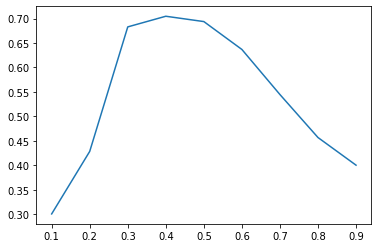

In [56]:
modelcii, tfvcii = train_validate(olid_traincii['tweet_cleaned'], olid_traincii['subtask_c_ii'],5, True)
modelcii, tfvcii = test(olid_traincii['tweet_cleaned'], olid_traincii['subtask_c_ii'], olid_testcii['tweet_cleaned'], olid_testcii['subtask_c_ii'],5, 0.6)



# Subtask C (iii)

(984, 823) (485, 823) (984,) (485,)
##### TRAINING DATA #####
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       719
           1       1.00      0.14      0.25       265

    accuracy                           0.77       984
   macro avg       0.88      0.57      0.55       984
weighted avg       0.82      0.77      0.70       984

AUC:  0.8755635447555565
##### VALIDATION DATA #####
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       355
           1       0.50      0.02      0.04       130

    accuracy                           0.73       485
   macro avg       0.62      0.51      0.44       485
weighted avg       0.67      0.73      0.63       485

AUC:  0.5752221018418202
##### TEST DATA #####
(113, 742) (113,)
              precision    recall  f1-score   support

           0       0.73      0.81      0.77        78
           1       0.44      0.34      0.39        35

  

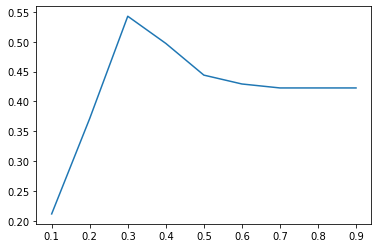

In [18]:
modelciii, tfvciii = train_validate(olid_trainciii['tweet_cleaned'], olid_trainciii['subtask_c_iii'],5,True)
modelciii, tfvciii, leciii = test(olid_trainciii['tweet_cleaned'], olid_trainciii['subtask_c_iii'], olid_testciii['tweet_cleaned'], olid_testciii['subtask_c_iii'],5, 0.3)

In [64]:
two_stage(olid_testc['tweet_cleaned'], olid_testc['subtask_c'], modelcii, modelciii, tfvcii, tfvciii, 0.5, 0.3)
    
    

              precision    recall  f1-score   support

           0       0.69      0.40      0.50        78
           1       0.58      0.91      0.71       100
           2       0.18      0.06      0.09        35

    accuracy                           0.58       213
   macro avg       0.48      0.45      0.43       213
weighted avg       0.55      0.58      0.53       213



# Feature Importances

In [41]:
def top_lr_feats(features,row, top_n=25, pos = True):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    if pos == True:
        topn_ids = np.argsort(row)[::-1][:top_n]
    else:
        topn_ids = np.argsort(row)[:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    return df.iloc[:,0].values, df.iloc[:,1].values

def plot_feat_imp(model, tfv, pos_label, neg_label):
    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(20,7))

    features = np.array(tfv.get_feature_names())
    x, y = top_lr_feats(features,  model.coef_[0],top_n = 20, pos = True)
    sns.barplot(x, y, ax = ax1)
    ax1.set_title('Class : ' + pos_label)
    x, y = top_lr_feats(features, model.coef_[0], top_n = 20, pos = False)
    sns.barplot(x, y, ax = ax2)
    ax2.set_title('Class : ' + neg_label)

    fig.text(0.5, 0.04, 'unigrams', ha='center')
    fig.text(0.05, 0.5, 'coeff', va='center',  rotation='vertical')
    fig.suptitle('Feature Importances', fontsize=16)
# sns.barplot(features,model.coef_[0])

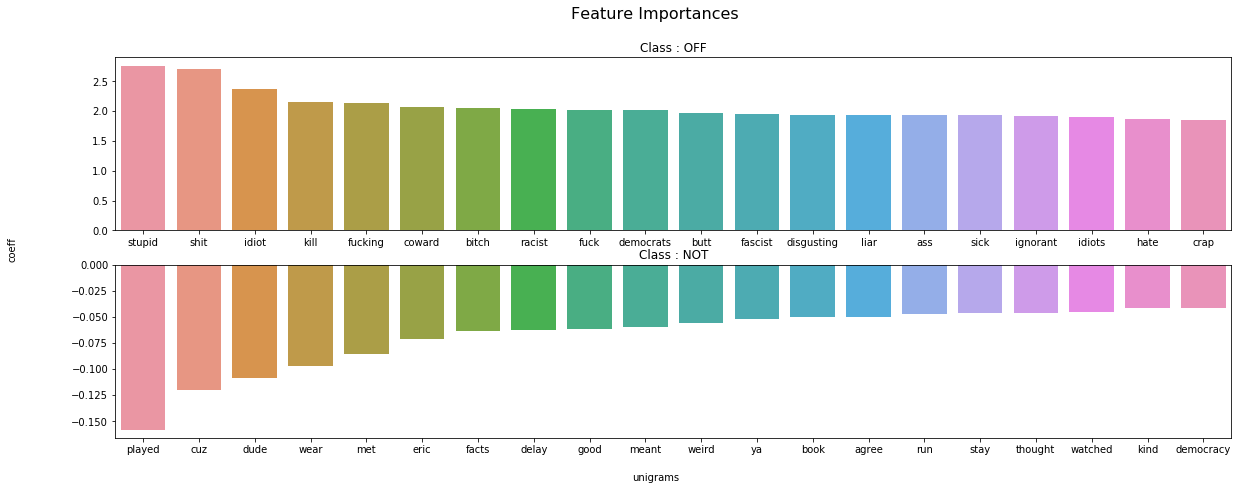

In [42]:
plot_feat_imp(modela, tfva, 'OFF', 'NOT')

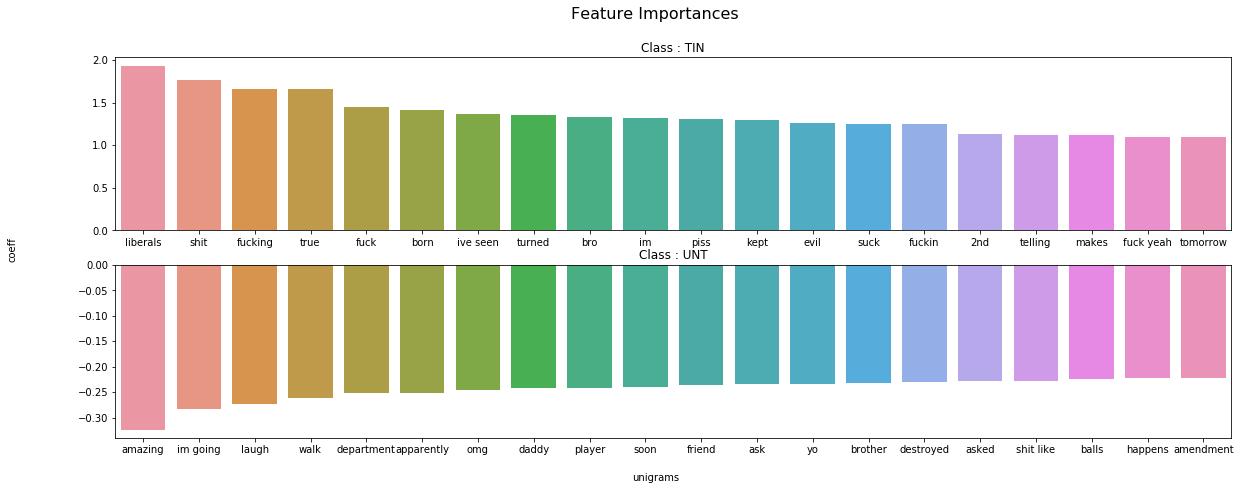

In [43]:
plot_feat_imp(modelb, tfvb, 'TIN', 'UNT')

In [13]:
# feature selection
# oversampling??